Ключевая идея:  
Судя по всему, с данными все в порядке, в случае с классическими методами обучения, при увеличении числа каналов и одновременном увеличении числа усреднений мы видим ожидаемые результаты.

Заметки:  
PCA не особо влияет на точность классификации  
Опробовать бустинг?    
Разобраться, что в итоге с нейросеткой  

In [34]:
import numpy as np
import os
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm import tqdm
from collections import Counter

In [35]:
# ML stuff
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import balanced_accuracy_score, f1_score, accuracy_score, precision_score, recall_score
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_validate
from sklearn.pipeline import make_pipeline

In [36]:
# Sampling
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

In [37]:
from eeg_dataset_utils import EEGDataset, EEGDatasetAdvanced, flatten

In [38]:
from collections import Counter

def sampling(dataset:EEGDataset=None, X:np.ndarray=None, y:np.ndarray=None,
             report=False, mode:list=None):
    '''
    
    mode -- 'real', 'over', 'under', 'balanced'
    '''
    
    if dataset:
        X = flatten(dataset.x.copy()) if len(dataset.x.shape)>2 else dataset.x.copy() # to flatten channels dim
        y = dataset.y.copy()
    else:
        X = flatten(X.copy()) if len(X.shape)>2 else X.copy()
        y = y.copy()
    count = Counter(y)
    if report:
        print(f'x shape: {X.shape}\ny shape: {y.shape}')
        print(f'class ratio: target={count[0]}, non-target={count[1]}')
    
    mode = mode if mode else ['real','over', 'under', 'balanced']
    
    data = dict.fromkeys(mode)
    
    if 'real' in mode:
        data['real']={'x':X, 'y':y}
    
    # Make downsampling
    if 'under' in mode:
        n_target = count[0]
        y_down = np.hstack([y[y==0], y[y==1][:n_target]])
        X_down = np.vstack([X[y==0], X[y==1][:n_target]])
        data['under'] = {'x':X_down, 'y':y_down}
        count = Counter(y_down)
        if report:
            print(f'x downsampled shape: {X_down.shape}\ny downsampled shape: {y_down.shape}')
            print(f'class ratio (downsampled): target={count[0]}, non-target={count[1]}')
    
    # Make oversampling
    if 'over' in mode:
        oversamler = SMOTE()
        X_over, y_over = oversamler.fit_resample(X, y)
        data['over'] = {'x':X_over, 'y':y_over}
        count = Counter(y_over)
        if report:
            print(f'x oversampled shape: {X_over.shape}\ny oversampled shape: {y_over.shape}')
            print(f'class ratio (oversampled): target={count[0]}, non-target={count[1]}')
    
    # Oversampling of minor class and undersampling of major class
    if 'balanced' in mode:
        over = SMOTE(sampling_strategy=0.5)
        under = RandomUnderSampler(sampling_strategy=0.5)
        pipe = ImbPipeline(steps=[('over', over), ('under', under)])
        X_balanced, y_balanced = pipe.fit_resample(X,y)
        data['balanced'] = {'x':X_balanced, 'y':y_balanced}
        count = Counter(y_balanced)
        if report:
            print(f'x balanced shape: {X_over.shape}\ny balanced shape: {y_over.shape}')
            print(f'class ratio (balanced): target={count[0]}, non-target={count[1]}')
    
    return data

In [39]:
def get_scores(y_true, y_pred, scoring=None):
        
    metrics = {
        'accuracy': accuracy_score,
        'balanced_accuracy': balanced_accuracy_score,
        'f1': f1_score,
        'precision': precision_score,
        'recall': recall_score
    }
    
    scoring = scoring if scoring else list(metrics.keys())
    
    scores = dict.fromkeys(scoring)
    
    for k, _ in scores.items():
        scores[k] = metrics[k](y_true, y_pred)
        
    return scores
    

In [40]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA

def pipeline(X, y, *models, models_names:list=None, scoring:list=['accuracy'],
             test_size=0.3, scaler=None, sampling_mode:list=None, do_pca=False, **kwargs):

    names = models_names if models_names else [*range(len(models))]
    assert len(names)==len(models), 'Number of names must be the same as the number of models'
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    
    if scaler:
        scaler.fit(X_train)
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)
    
    if do_pca:
        pca = PCA(**kwargs)
        pca.fit(X_train)
        X_train = pca.transform(X_train)
        X_test = pca.transform(X_test)
    
    data = sampling(X=X_train, y=y_train, mode=sampling_mode)
    
    result = []
    cms = []
    mdls = []
    smpl = []
    
    for sampl, train_set in data.items():
        models_list = list(models).copy()
        for name, model in zip(models_names, models_list):
            model.fit(train_set['x'], train_set['y'])
            y_pred = model.predict(X_test)
            res = get_scores(y_test, y_pred, scoring)
            res.update({'model':name,'sampling':sampl})
            cm = confusion_matrix(y_test, y_pred)
            cms.append(cm) 
            mdls.append(name)
            smpl.append(sampl)
            result.append(pd.Series(res))
    
    return pd.DataFrame(result), {'sampling': smpl, 'model': mdls, 'cm': cms}
            

def get_scores(y_true, y_pred, scoring=None):
        
    metrics = {
        'accuracy': accuracy_score,
        'balanced_accuracy': balanced_accuracy_score,
        'f1': f1_score,
        'precision': precision_score,
        'recall': recall_score
    }
    
    scoring = scoring if scoring else list(metrics.keys())
    
    scores = dict.fromkeys(scoring)
    
    for k, v in scores.items():
        scores[k] = metrics[k](y_true, y_pred)
        
    return scores
    
        

In [8]:
# Наборы каналов
ch_set1 = ['Pz']
ch_set3 = ['Pz', 'Cz', 'POz']
ch_set7 = ['Pz', 'Cz', 'POz', 'P3', 'P4', 'PO3', 'PO4']
ch_set9 = ['Cz', 'Pz', 'POz', 'P3', 'P4', 'P7', 'P8', 'PO3', 'PO4']
ch_set13 = ['Cz', 'Pz', 'POz', 'P1', 'P2', 'P3','P4', 'P5', 'P6', 'P7', 'P8', 'PO3', 'PO4']
ch_set15 = ['Cz', 'Pz', 'POz', 'P1', 'P2', 'P3','P4', 'P5', 'P6', 'P7', 'P8', 'PO3', 'PO4', 'O1', 'O2']

### Проверим, влияет ли сжатие датасета на качество данных

In [12]:
# dataset1 = EEGDataset('./P300BCI_DataSet/', subject='ik')
dataset1 = EEGDatasetAdvanced('./P300BCI_DataSet/', subjects='ik', load_cache=True)
dataset1.pick_channels(['Pz'])
dataset2 = EEGDatasetAdvanced('./P300BCI_DataSet/', subjects='ik', load_cache=True, cache_dir_name='eeg_cache_compressed')
dataset2.pick_channels(['Pz'])

In [81]:
epoch = 0
x1 = dataset1[epoch][0].reshape(301)
y1 = dataset1[epoch][1].int().item()
x2 = dataset2[epoch][0].reshape(151)
y2 = dataset2[epoch][1].int().item()

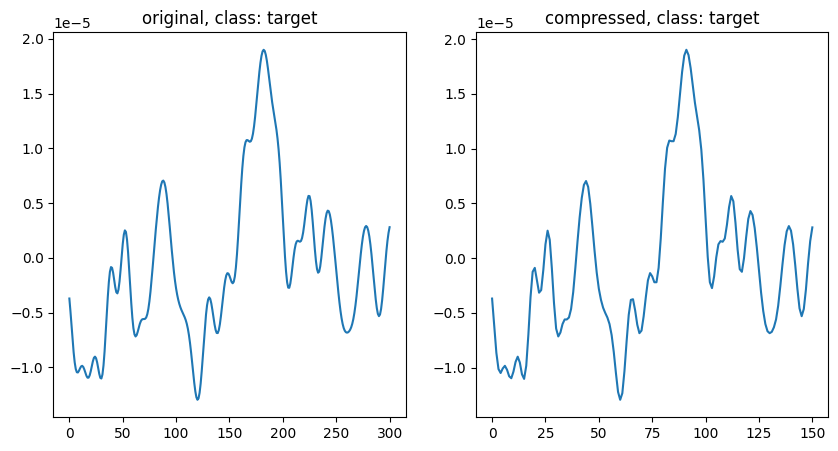

In [82]:
plt.figure(figsize=(10, 5))
plt.subplot(1,2,1)
plt.plot(x1)
plt.title(f'original, class: {dataset1.labels_info[y1]}')
plt.subplot(1,2,2)
plt.plot(x2)
plt.title(f'compressed, class: {dataset2.labels_info[y2]}')
plt.show()

Сжатие не искажает исходные данные

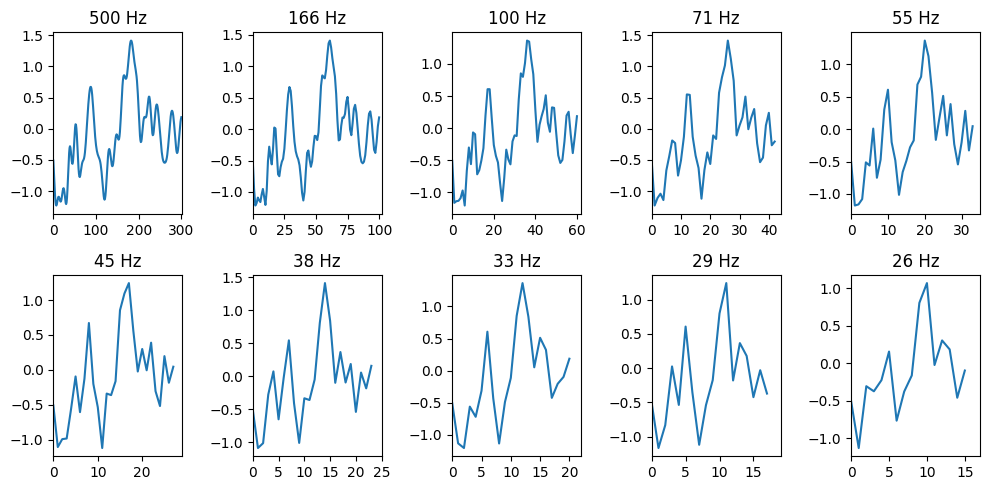

In [28]:
# Проверка на сжатие в большее количество раз

dataset = EEGDataset('./P300BCI_DataSet/', subject='ik')
dataset.pick_channels(['Pz'])
X = flatten(dataset.x.copy())
X = StandardScaler().fit_transform(X)
fig, axes = plt.subplots(2,5, figsize=(10,5))
for i, ax in zip(range(1,21,2), axes.ravel()):
    x = X[0,::i] # -> Resampling
    ax.plot(x)
    ax.set_title(f'{500//i} Hz')
    ax.set_xlim(0, len(x)+1)
    ax.locator_params(axis='x', nbins=5)
fig.tight_layout()
plt.show()

### Проведем интерпретацию LDA и SVM 

In [169]:
dataset = EEGDataset('./P300BCI_DataSet/', subject='ik')
dataset.pick_channels(['Pz'])
X = flatten(dataset.x.copy())
y = dataset.y.copy()

In [170]:
time = np.arange(0,601,2)

In [171]:
X = RobustScaler().fit_transform(X)

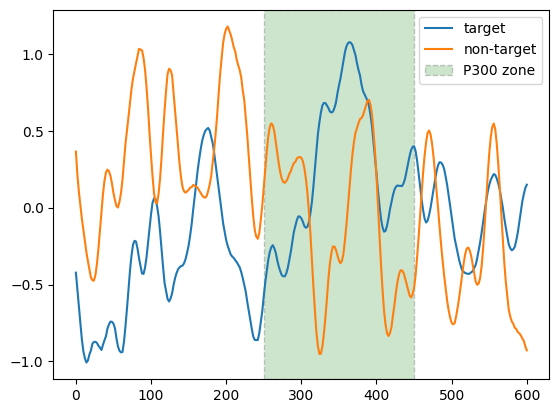

In [179]:
# Выведем данные для лучшей интерпретации последующих графиков
plt.plot(time, X[0], label=dataset.labels_info[y[0]])
plt.plot(time, X[-30], label=dataset.labels_info[y[-30]])
plt.axvspan(250,450, facecolor='green', edgecolor='k', linestyle='--', alpha=0.2, label='P300 zone')
plt.legend()
plt.show()

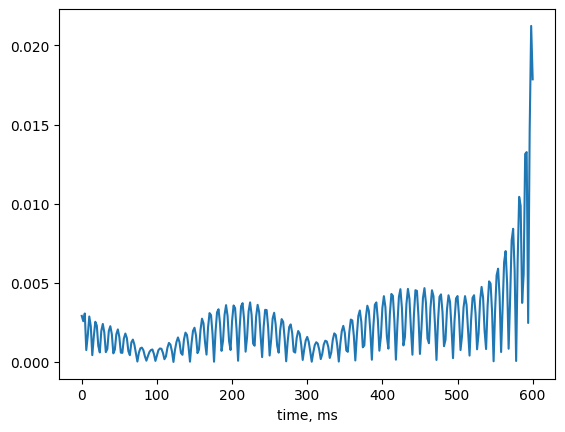

In [63]:
svm = SVC(kernel='linear').fit(X, y)
svm_coef = svm.coef_
plt.plot(time, np.abs(svm_coef.reshape(svm_coef.shape[1])))
plt.xlabel('time, ms')
plt.show()

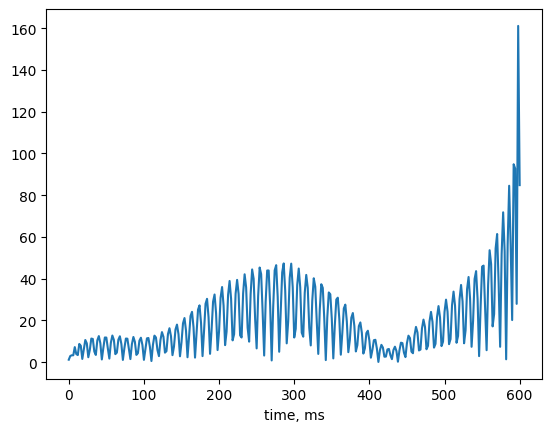

In [64]:
lda = LDA().fit(X, y)
lda_coef = lda.coef_
plt.plot(time, np.abs(lda_coef.reshape(lda_coef.shape[1])))
plt.xlabel('time, ms')
plt.show()

Для разных испытуемых сохраняется то, что наибольшая значимость признаков определяется концу и иногда началу фрагмента ЭЭГ.

Попробуем обрезать сигнал, чтобы оставить только центральную часть 100-500 мс

In [65]:
X2 = X[:, 50:200]
lda = LDA().fit(X2, y)
svm = SVC(kernel='linear').fit(X2, y)

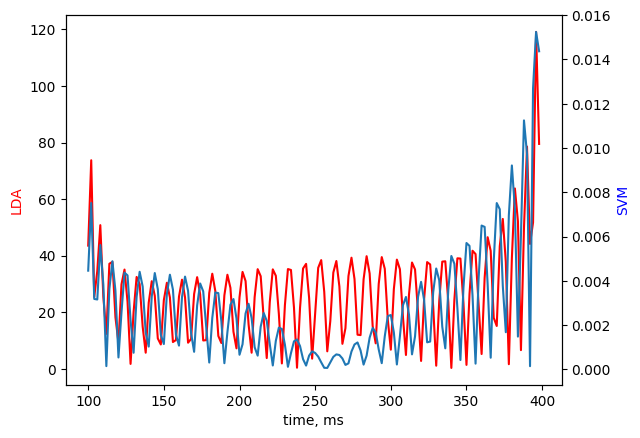

In [71]:
times = np.arange(100, 400, 2)
plt.plot(times, np.abs(lda.coef_.reshape(lda.coef_.shape[1])), label='LDA', c='r')
plt.ylabel('LDA', c='r')
plt.xlabel('time, ms')
plt.twinx()
plt.plot(times, np.abs(svm.coef_.reshape(svm.coef_.shape[1])), label='SVM')
plt.ylabel('SVM', c='b')
plt.show()

Все равно сохраняется превалирование начала и конца отрезка...

Проведем манипуляции по уравнению экземпляров классов

In [75]:
data = sampling(X=X, y=y, report=True)

x shape: (3599, 301)
y shape: (3599,)
class ratio: target=400, non-target=3199
x downsampled shape: (800, 301)
y downsampled shape: (800,)
class ratio (downsampled): target=400, non-target=400
x oversampled shape: (6398, 301)
y oversampled shape: (6398,)
class ratio (oversampled): target=3199, non-target=3199
x balanced shape: (6398, 301)
y balanced shape: (6398,)
class ratio (balanced): target=1599, non-target=3198


In [79]:
result = dict().fromkeys(data)
for k, d in tqdm(data.items()):
    lda = LDA().fit(d['x'], d['y'])
    svm = SVC(kernel='linear').fit(d['x'], d['y'])
    result[k] = {
        'LDA': np.abs(lda.coef_.reshape(lda.coef_.shape[1])),
        'SVM': np.abs(svm.coef_.reshape(svm.coef_.shape[1]))
    }
    

100%|██████████| 4/4 [00:26<00:00,  6.69s/it]


In [110]:
# To smooth oscilatoins

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'same') / w

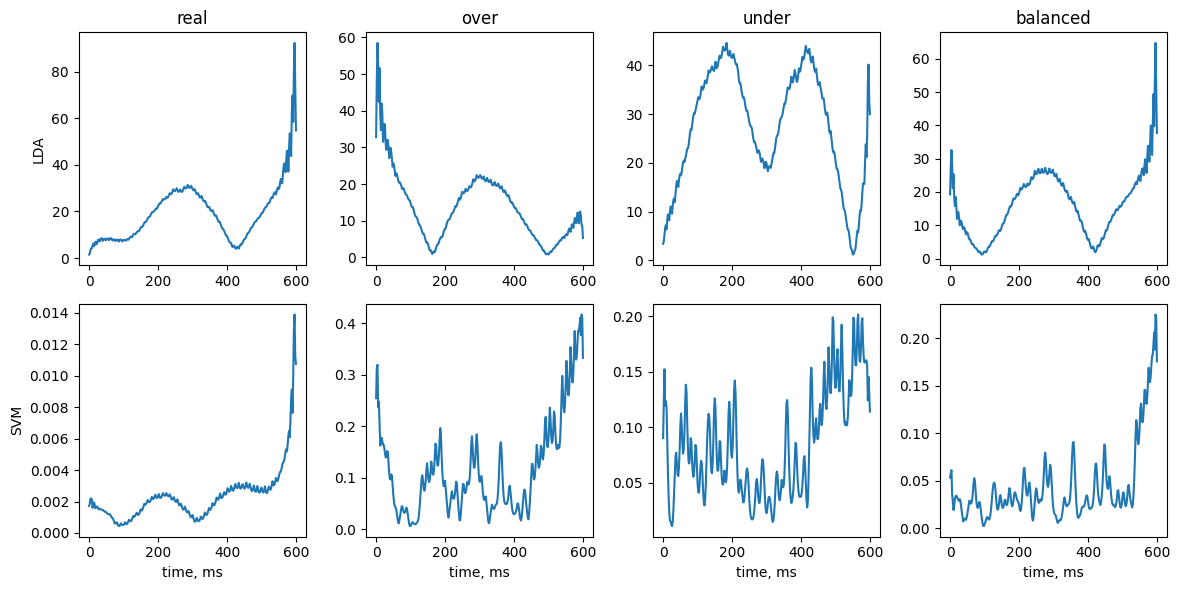

In [128]:
fig, axes = plt.subplots(2,4, figsize=(12,6))
n = 0
time = np.arange(0,601,2)
axes = axes.ravel()
for k, d in result.items():
    ax = axes[n]
    ax.plot(time, moving_average(d['LDA'], 5))
    ax.set_title(k)
    ax = axes[n+4]
    ax.plot(time, moving_average(d['SVM'], 5))
    ax.set_xlabel('time, ms')
    n+=1
axes[0].set_ylabel('LDA')
axes[4].set_ylabel('SVM')    
fig.tight_layout()

Манипуляции с изменением числа экземпляров классов не помогают избежать большего веса для "хвостов" фрагметов ЭЭГ

## Посмотрим на классификацию

Посмотреть на Confusion matrix оказывается информативно, т.к. видно, что обучение все-таки происходит. Важнее, чтобы происходило узнавание класса 0 (target).

In [29]:
dataset = EEGDataset('./P300BCI_DataSet/', subject='ak')
dataset.pick_channels(['Pz'])
X = flatten(dataset.x.copy())
y = dataset.y.copy()

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
scaler = RobustScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [31]:
data = sampling(X=X_train, y=y_train, report=True)

x shape: (2412, 301)
y shape: (2412,)
class ratio: target=256, non-target=2156
x downsampled shape: (512, 301)
y downsampled shape: (512,)
class ratio (downsampled): target=256, non-target=256
x oversampled shape: (4312, 301)
y oversampled shape: (4312,)
class ratio (oversampled): target=2156, non-target=2156
x balanced shape: (4312, 301)
y balanced shape: (4312,)
class ratio (balanced): target=1078, non-target=2156


In [32]:
from sklearn.metrics import confusion_matrix

correct_target = []
correct_nontarget = []
samplings = []
models = []
metrics = []
cms = []
for k, v in tqdm(data.items()):
    for name, model in zip(['LDA', 'linear', 'rbf', 'sigmoid'],
                           [LDA(),
                            SVC(kernel='linear', class_weight='balanced', random_state=42),
                            SVC(kernel='rbf', class_weight='balanced', random_state=42),
                            SVC(kernel='sigmoid', class_weight='balanced',random_state=42)]):
        model.fit(v['x'], v['y'])
        y_pred = model.predict(X_test)
        cm = confusion_matrix(y_test, y_pred)
        correct_target.append(cm[0,0])
        correct_nontarget.append(cm[1,1])
        cms.append(cm)
        samplings.append(k)
        models.append(name)
        metrics.append(get_scores(y_test, y_pred))

100%|██████████| 4/4 [00:22<00:00,  5.70s/it]


In [34]:
count = pd.Series(y_test).value_counts()
print(count)

1    1044
0     144
dtype: int64


In [35]:
df = pd.DataFrame({'target_hits':correct_target, 'nontarget_hits':correct_nontarget, 'sampling':samplings, 'model':models})
df['target_recognition'] = df['target_hits']/count[0]
df['nontarget_recognition'] = df['nontarget_hits']/count[1]
df.head()

,target_hits,nontarget_hits,sampling,model,target_recognition,nontarget_recognition
0,3,1044,real,LDA,0.020833,1.000000
1,67,694,real,linear,0.465278,0.664751
2,45,859,real,rbf,0.312500,0.822797
3,78,517,real,sigmoid,0.541667,0.495211
4,74,704,over,LDA,0.513889,0.674330


In [26]:
df.query(" model=='linear' & sampling.isin(['under', 'over']) ")

,target_hits,nontarget_hits,sampling,model,target_recognition,nontarget_recognition
5,66,708,over,linear,0.458333,0.678161
9,72,640,under,linear,0.500000,0.613027


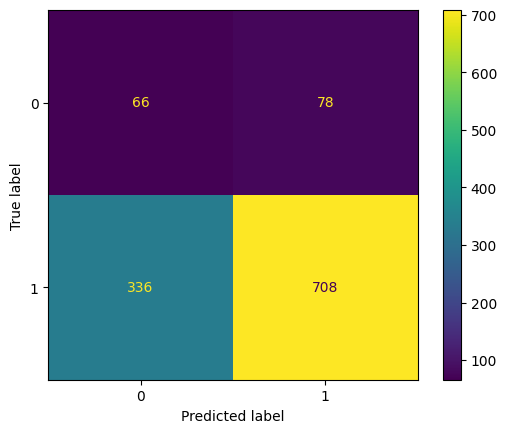

In [27]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay(cms[5]).plot()

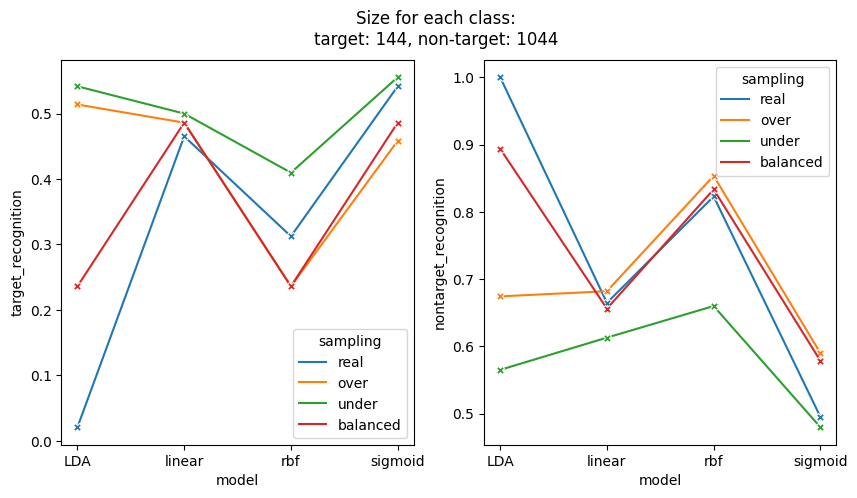

In [36]:
# Balanced SVM
fig, axes = plt.subplots(1,2,figsize=(10,5))
sns.lineplot(df, x='model', y='target_recognition', hue='sampling', marker='X', ax=axes[0])
sns.lineplot(df, x='model', y='nontarget_recognition', hue='sampling', marker='X', ax=axes[1])
count = pd.Series(y_test).value_counts()
fig.suptitle(f'Size for each class:\ntarget: {count[0]}, non-target: {count[1]}')
plt.show()

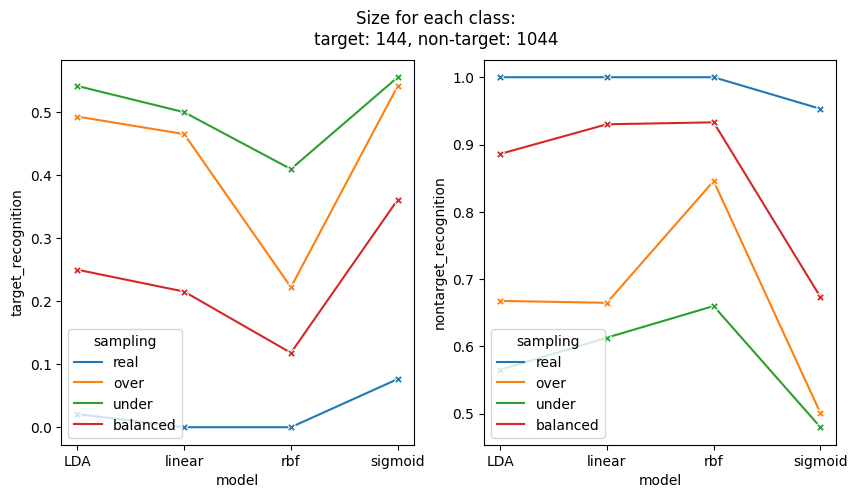

In [ ]:
# Non balanced SVM
fig, axes = plt.subplots(1,2,figsize=(10,5))
sns.lineplot(df, x='model', y='target_recognition', hue='sampling', marker='X', ax=axes[0])
sns.lineplot(df, x='model', y='nontarget_recognition', hue='sampling', marker='X', ax=axes[1])
count = pd.Series(y_test).value_counts()
fig.suptitle(f'Size for each class:\ntarget: {count[0]}, non-target: {count[1]}')
plt.show()

Как видно из графиков выше, наибольшее узнавание target-класса при адекватных значениях узнавания non-target-класса отмечается для линейного SVM классификатора. Если добавлять веса классов, то видно, что теряется эффект от сэмплинга, т.е. обучение происходит адекватно и на несбалансированном датасете (что и логично). Но при этом модель учится дольше, поэтому, возможно, имеет смысл оставить оверсэмплинг без добавления весов в классификатор.

In [22]:
X_train, y_train = data['over']['x'], data['over']['y']

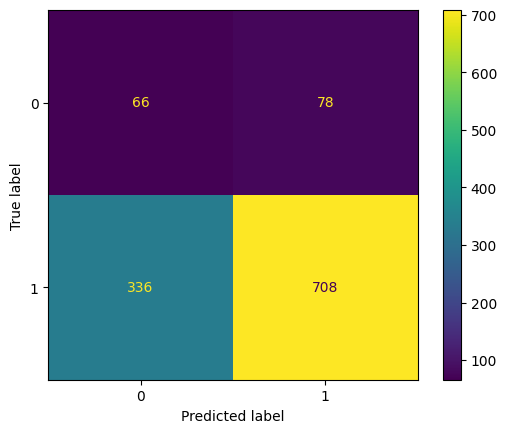

In [25]:
svm = SVC(kernel='linear')
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()

## Число каналов

In [31]:
dataset = EEGDataset('./P300BCI_DataSet/', subject='ik')
dataset.pick_channels(ch_set15)
X = flatten(dataset.x.copy())
y = dataset.y.copy()

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
scaler = RobustScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [37]:
data = sampling(X=X_train, y=y_train)
X_trainR = data['real']['x']
y_trainR = data['real']['y']

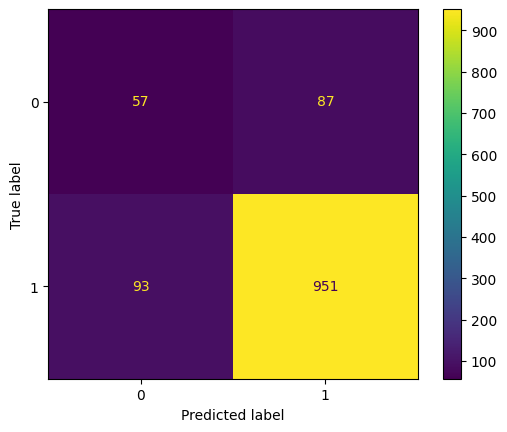

In [38]:
svm = SVC(kernel='linear')
svm.fit(X_trainR, y_trainR)
y_pred = svm.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()

## Число усреднений

In [203]:
dataset = EEGDataset('./P300BCI_DataSet/', subject='ik')
dataset.pick_channels(ch_set15)
dataset.average(9)
X = flatten(dataset.x.copy())
y = dataset.y.copy()

In [204]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
scaler = RobustScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [205]:
data = sampling(X=X_train, y=y_train)
X_trainR = data['over']['x']
y_trainR = data['over']['y']

1.0    114
0.0     18
dtype: int64


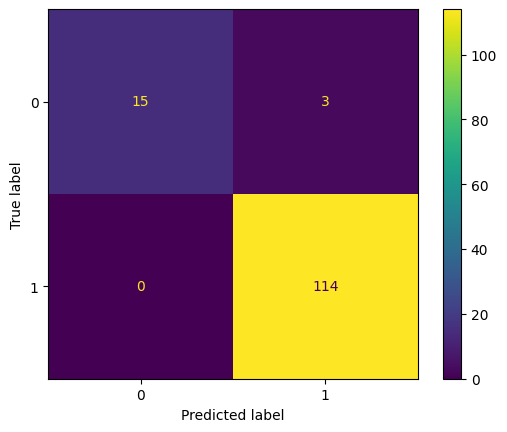

In [206]:
svm = SVC(kernel='linear', random_state=42)
svm.fit(X_trainR, y_trainR)
y_pred = svm.predict(X_test)
print(pd.Series(y_test).value_counts())
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()

In [101]:
palette = sns.palettes.color_palette()

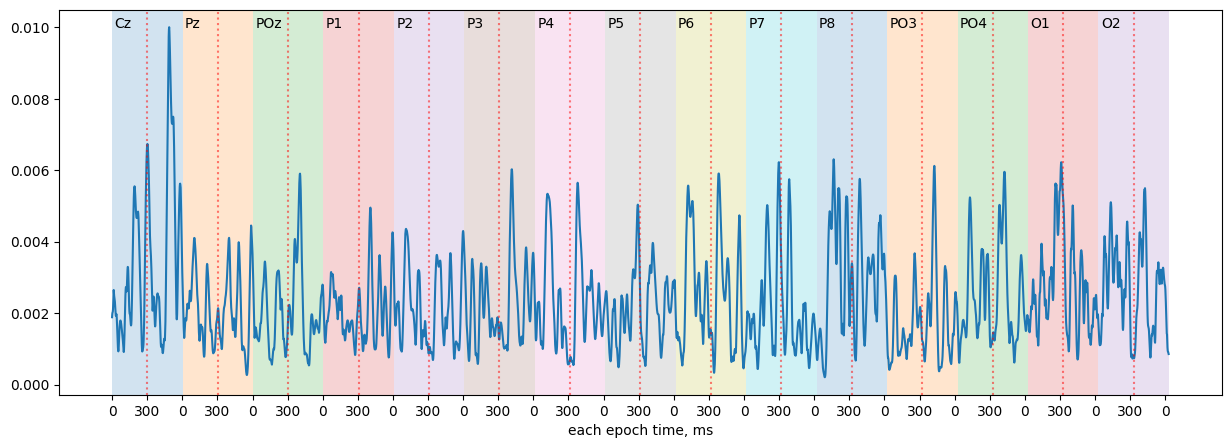

In [207]:
# Веса признаков для большего числа электродов

plt.figure(figsize=(15,5))
coef = moving_average(np.abs(svm.coef_.reshape(svm.coef_.shape[1])), 15)
xtl = np.append(np.tile(np.array([0,300]), 15), 0)
plt.plot(coef)
for i, ch, c in zip(range(0,len(coef),301), ch_set15, palette+palette):
    plt.axvline(i+150, c='r', ls=':', alpha=0.5)
    plt.axvspan(i,i+301, alpha=0.2, facecolor=c)
    plt.text(i+10, coef.max(), ch)
    plt.xticks(np.arange(0, len(coef), 150), xtl)
plt.xlabel('each epoch time, ms')
plt.show()

## PCA

In [249]:
dataset = EEGDataset('./P300BCI_DataSet/', subject='ik')
dataset.pick_channels(ch_set7)
dataset.average(4)
X = flatten(dataset.x.copy())
y = dataset.y.copy()

In [250]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
scaler = RobustScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [251]:
data = sampling(X=X_train, y=y_train)
X_trainR = data['over']['x']
y_trainR = data['over']['y']

In [252]:
from sklearn.decomposition import PCA
svm = SVC(kernel='linear', random_state=42)
pca = PCA(n_components=20)

In [253]:
pca.fit(X_trainR, y_trainR)
pca.explained_variance_ratio_

array([0.40318231, 0.0743546 , 0.04970617, 0.03966912, 0.0353091 ,
       0.03091011, 0.02974159, 0.02831314, 0.02242124, 0.02087225,
       0.01929524, 0.01672709, 0.01609375, 0.01378454, 0.01259908,
       0.01052283, 0.00982451, 0.00873074, 0.00726594, 0.00657991])

In [254]:
X_trainR = pca.transform(X_trainR)
X_testR = pca.transform(X_test)

In [255]:
svm.fit(X_trainR, y_trainR)
y_pred = svm.predict(X_testR)
get_scores(y_test, y_pred)

{'accuracy': 0.8249158249158249,
 'balanced_accuracy': 0.7893675027262814,
 'f1': 0.8938775510204082,
 'precision': 0.9605263157894737,
 'recall': 0.8358778625954199}

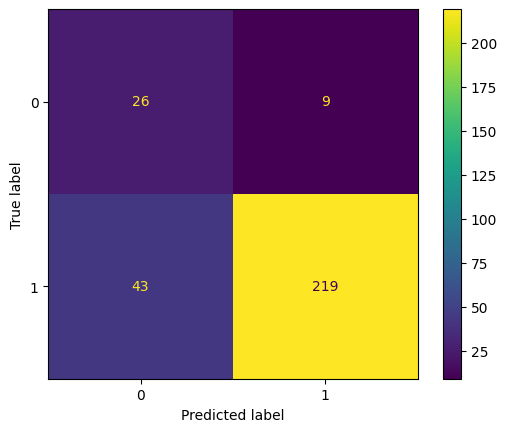

In [256]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = (confusion_matrix(y_test, y_pred))
display = ConfusionMatrixDisplay(cm)
display.plot()

## Каналы + электроды

In [41]:
dataset = EEGDataset('./P300BCI_DataSet/', subject='ik')
dataset.data = dataset.data[:,:,::4] # 500/14 -> 35 Hz, like in article doi:10.1109/ACCESS.2021.3089998

In [59]:
ch_set1 = ['Pz']
ch_set4 = ['Pz', 'POz', 'Cz', 'Fz']
ch_set8 = ['P7', 'P3', 'Pz', 'P4', 'P8', 'POz', 'Cz', 'Fz']
ch_set15 = ['Cz', 'Pz', 'POz', 'P1', 'P2', 'P3','P4', 'P5', 'P6', 'P7', 'P8', 'PO3', 'PO4', 'O1', 'O2']

In [43]:
results = []
conf_mat = []
channels = []
n_epochs = []
for ch in [ch_set1, ch_set4, ch_set8, ch_set15]:
    dataset.pick_channels(ch)
    for n_epoch in tqdm(np.arange(1,11,1)):
        dataset.average(n_epoch)
        X = flatten(dataset.x.copy())
        y = dataset.y.copy()
        res, cms = pipeline(X, y, LDA(), SVC(kernel='linear', random_state=42),
                            models_names=['LDA','SVM'], scaler=RobustScaler(),
                            scoring=['accuracy', 'balanced_accuracy', 'f1', 'precision', 'recall'])
                            # do_pca=True, n_components=20)
        results.append(res)
        conf_mat.append(cms)
        channels.append(len(ch))
        n_epochs.append(n_epoch)

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [01:48<00:00, 10.88s/it]


In [44]:
results = [df.assign(n_ch=ch, n_epochs=n_ep) for df, ch, n_ep in zip(results, channels, n_epochs)]

In [45]:
df = pd.concat(results)
df = df.melt(id_vars=['model', 'sampling', 'n_ch', 'n_epochs'], var_name='metric')
df.head()

,model,sampling,n_ch,n_epochs,metric,value
0,LDA,real,1,1,accuracy,0.886111
1,SVM,real,1,1,accuracy,0.894444
2,LDA,over,1,1,accuracy,0.630556
3,SVM,over,1,1,accuracy,0.627778
4,LDA,under,1,1,accuracy,0.591667


In [46]:
# df.to_csv('one_subject_channels_x_n_epochs_125Hz.csv')
# df = pd.read_csv('one_subject_channels_x_n_epochs_35Hz.csv')

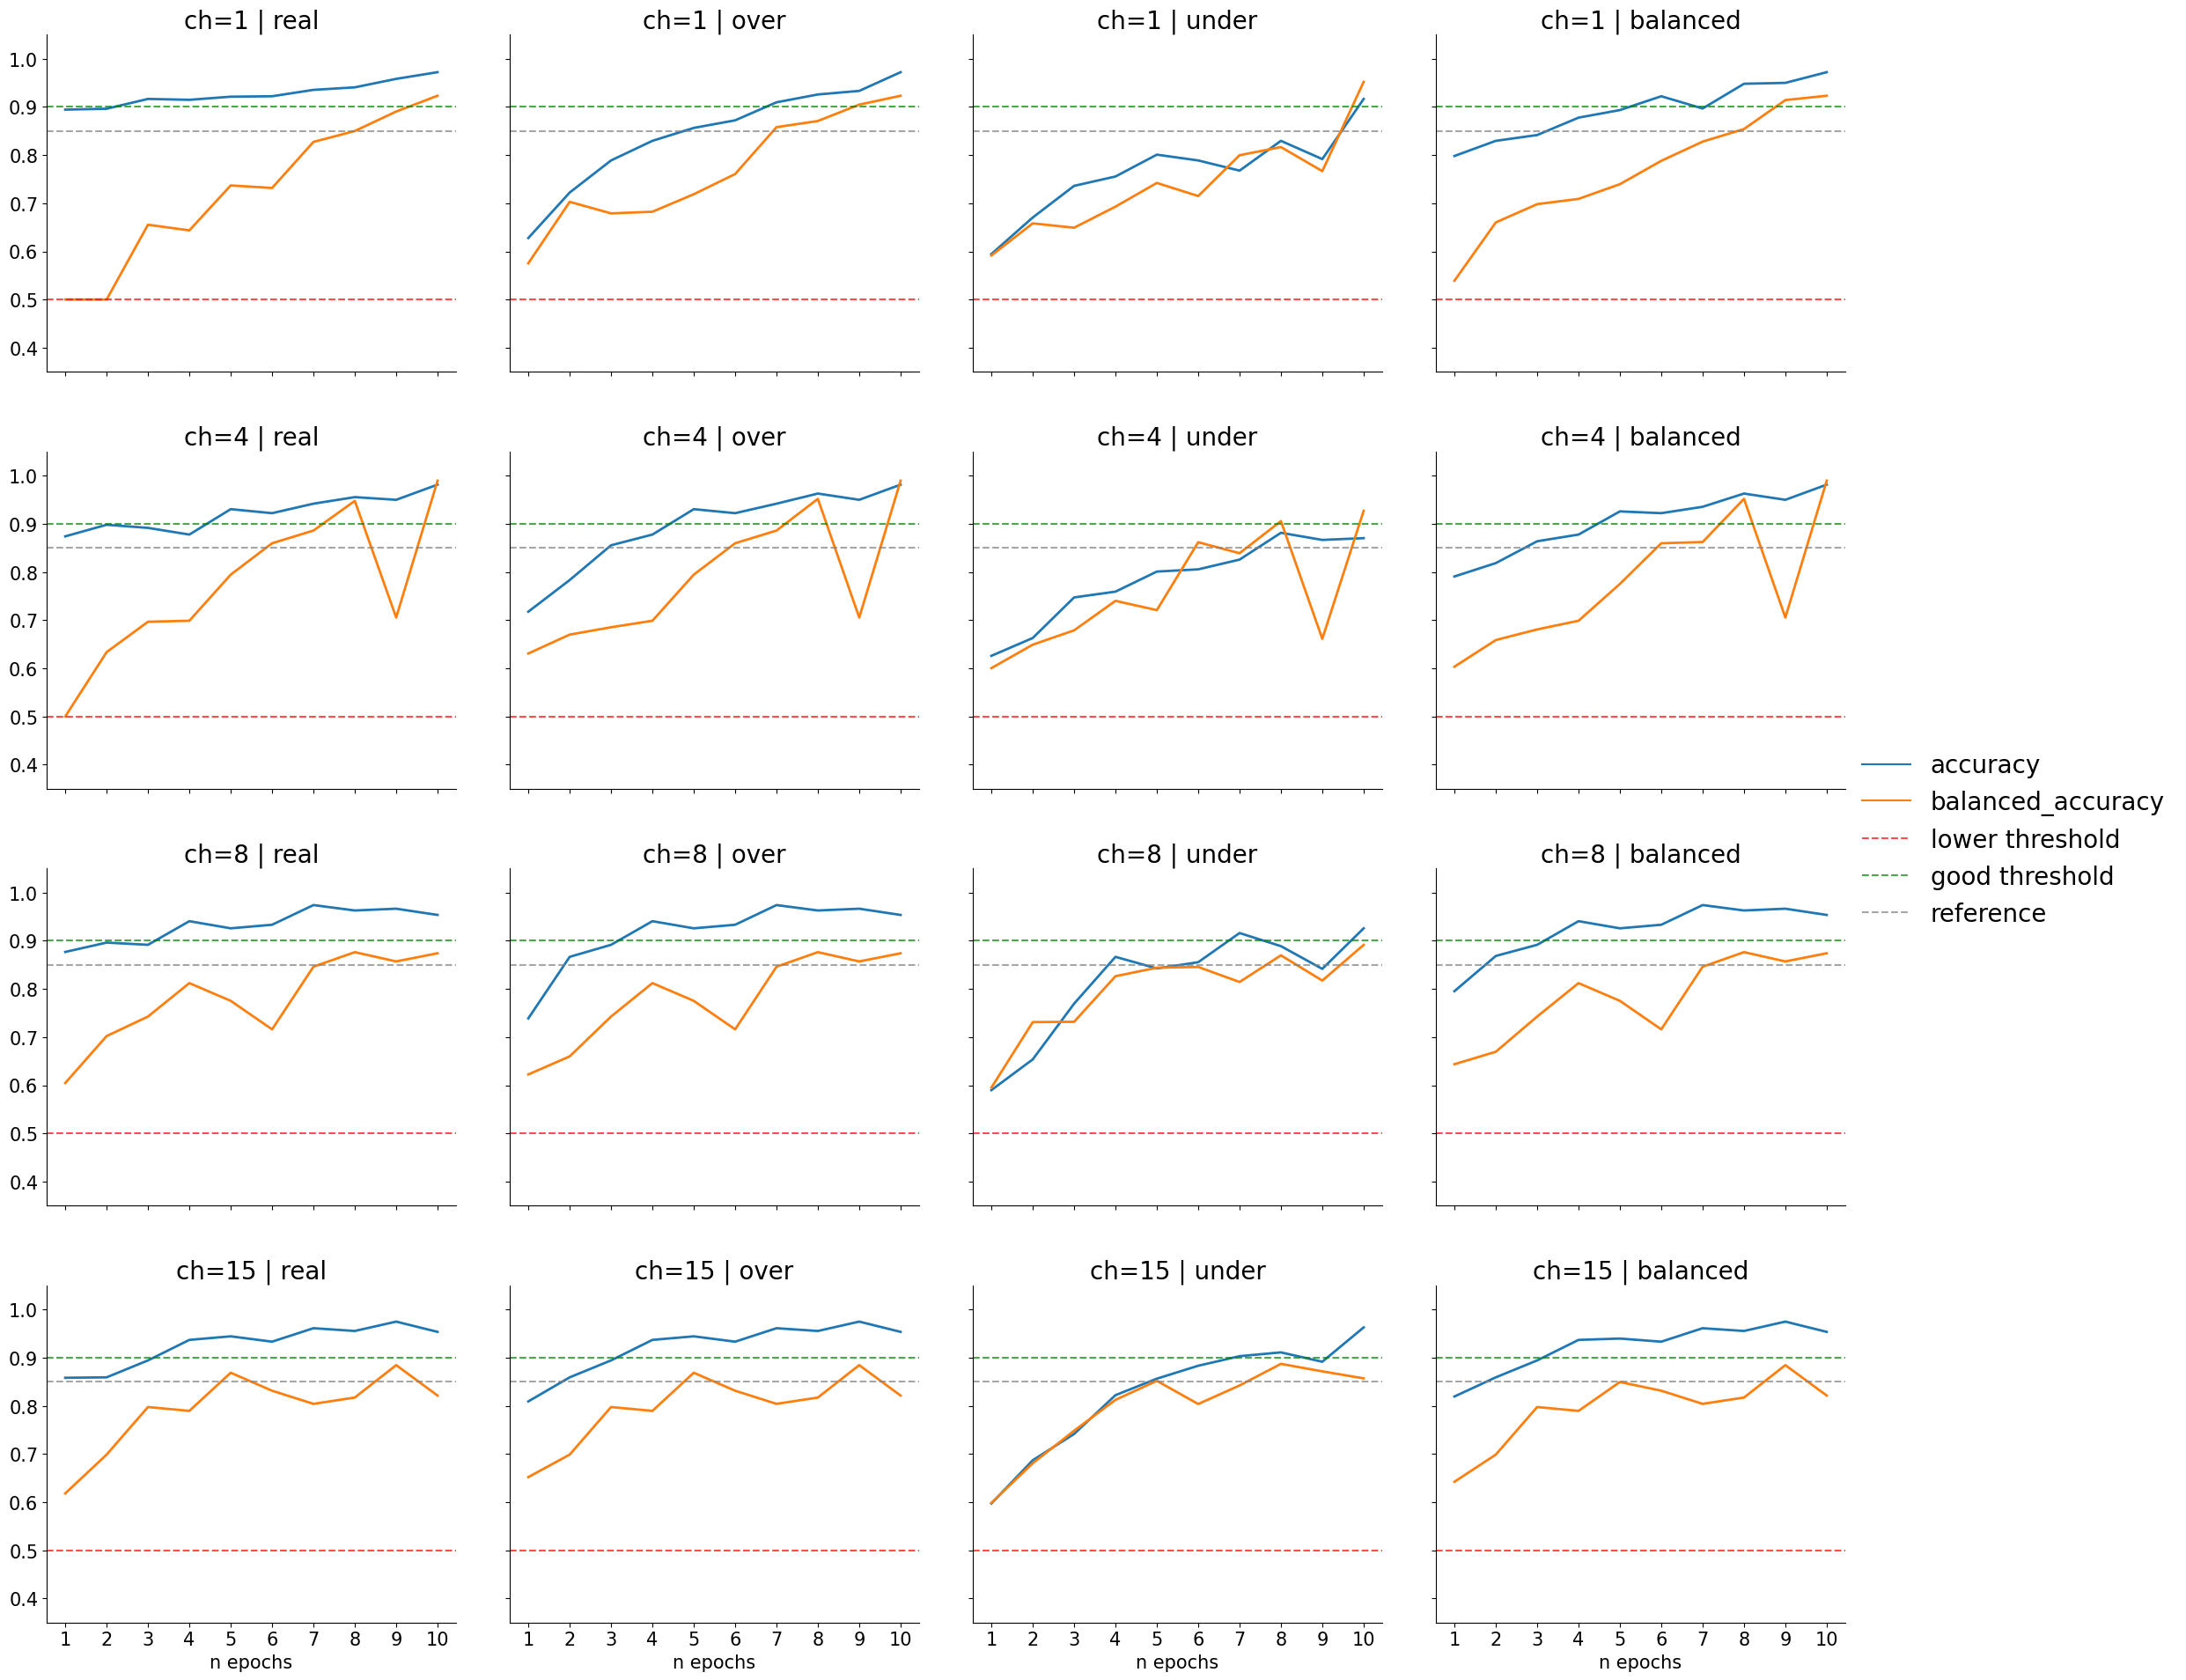

In [47]:
# 125 Hz
df = pd.read_csv('one_subject_channels_x_n_epochs_125Hz.csv')
with plt.rc_context({'xtick.labelsize':15,
                     'ytick.labelsize':15}):
    g = sns.relplot(df[(df.model=='SVM') & (df.metric.isin(['accuracy', 'balanced_accuracy']))],
                    x='n_epochs', y='value', hue='metric', col='sampling', row='n_ch', kind='line', linewidth=2)
    g.set_titles('ch={row_name} | {col_name}', size=20)
    g.map(plt.axhline, y=0.5, c='r', ls='--', label='lower threshold', alpha=0.7)
    g.map(plt.axhline, y=0.9, c='green', ls='--', label='good threshold', alpha=0.7)
    g.map(plt.axhline, y=0.85, c='grey', ls='--', label='reference', alpha=0.7)
    g.set_ylabels('')
    g.set_xlabels('n epochs', size=15)
    g.set(ylim=(0.35,1.05), xticks=np.arange(1,11,1))
    g.fig.tight_layout(pad=4)
    g.legend.remove()
    g.add_legend(fontsize=20)
    # plt.savefig('epochs_one_subject_all_samplings.jpg', dpi=300)
    plt.show()

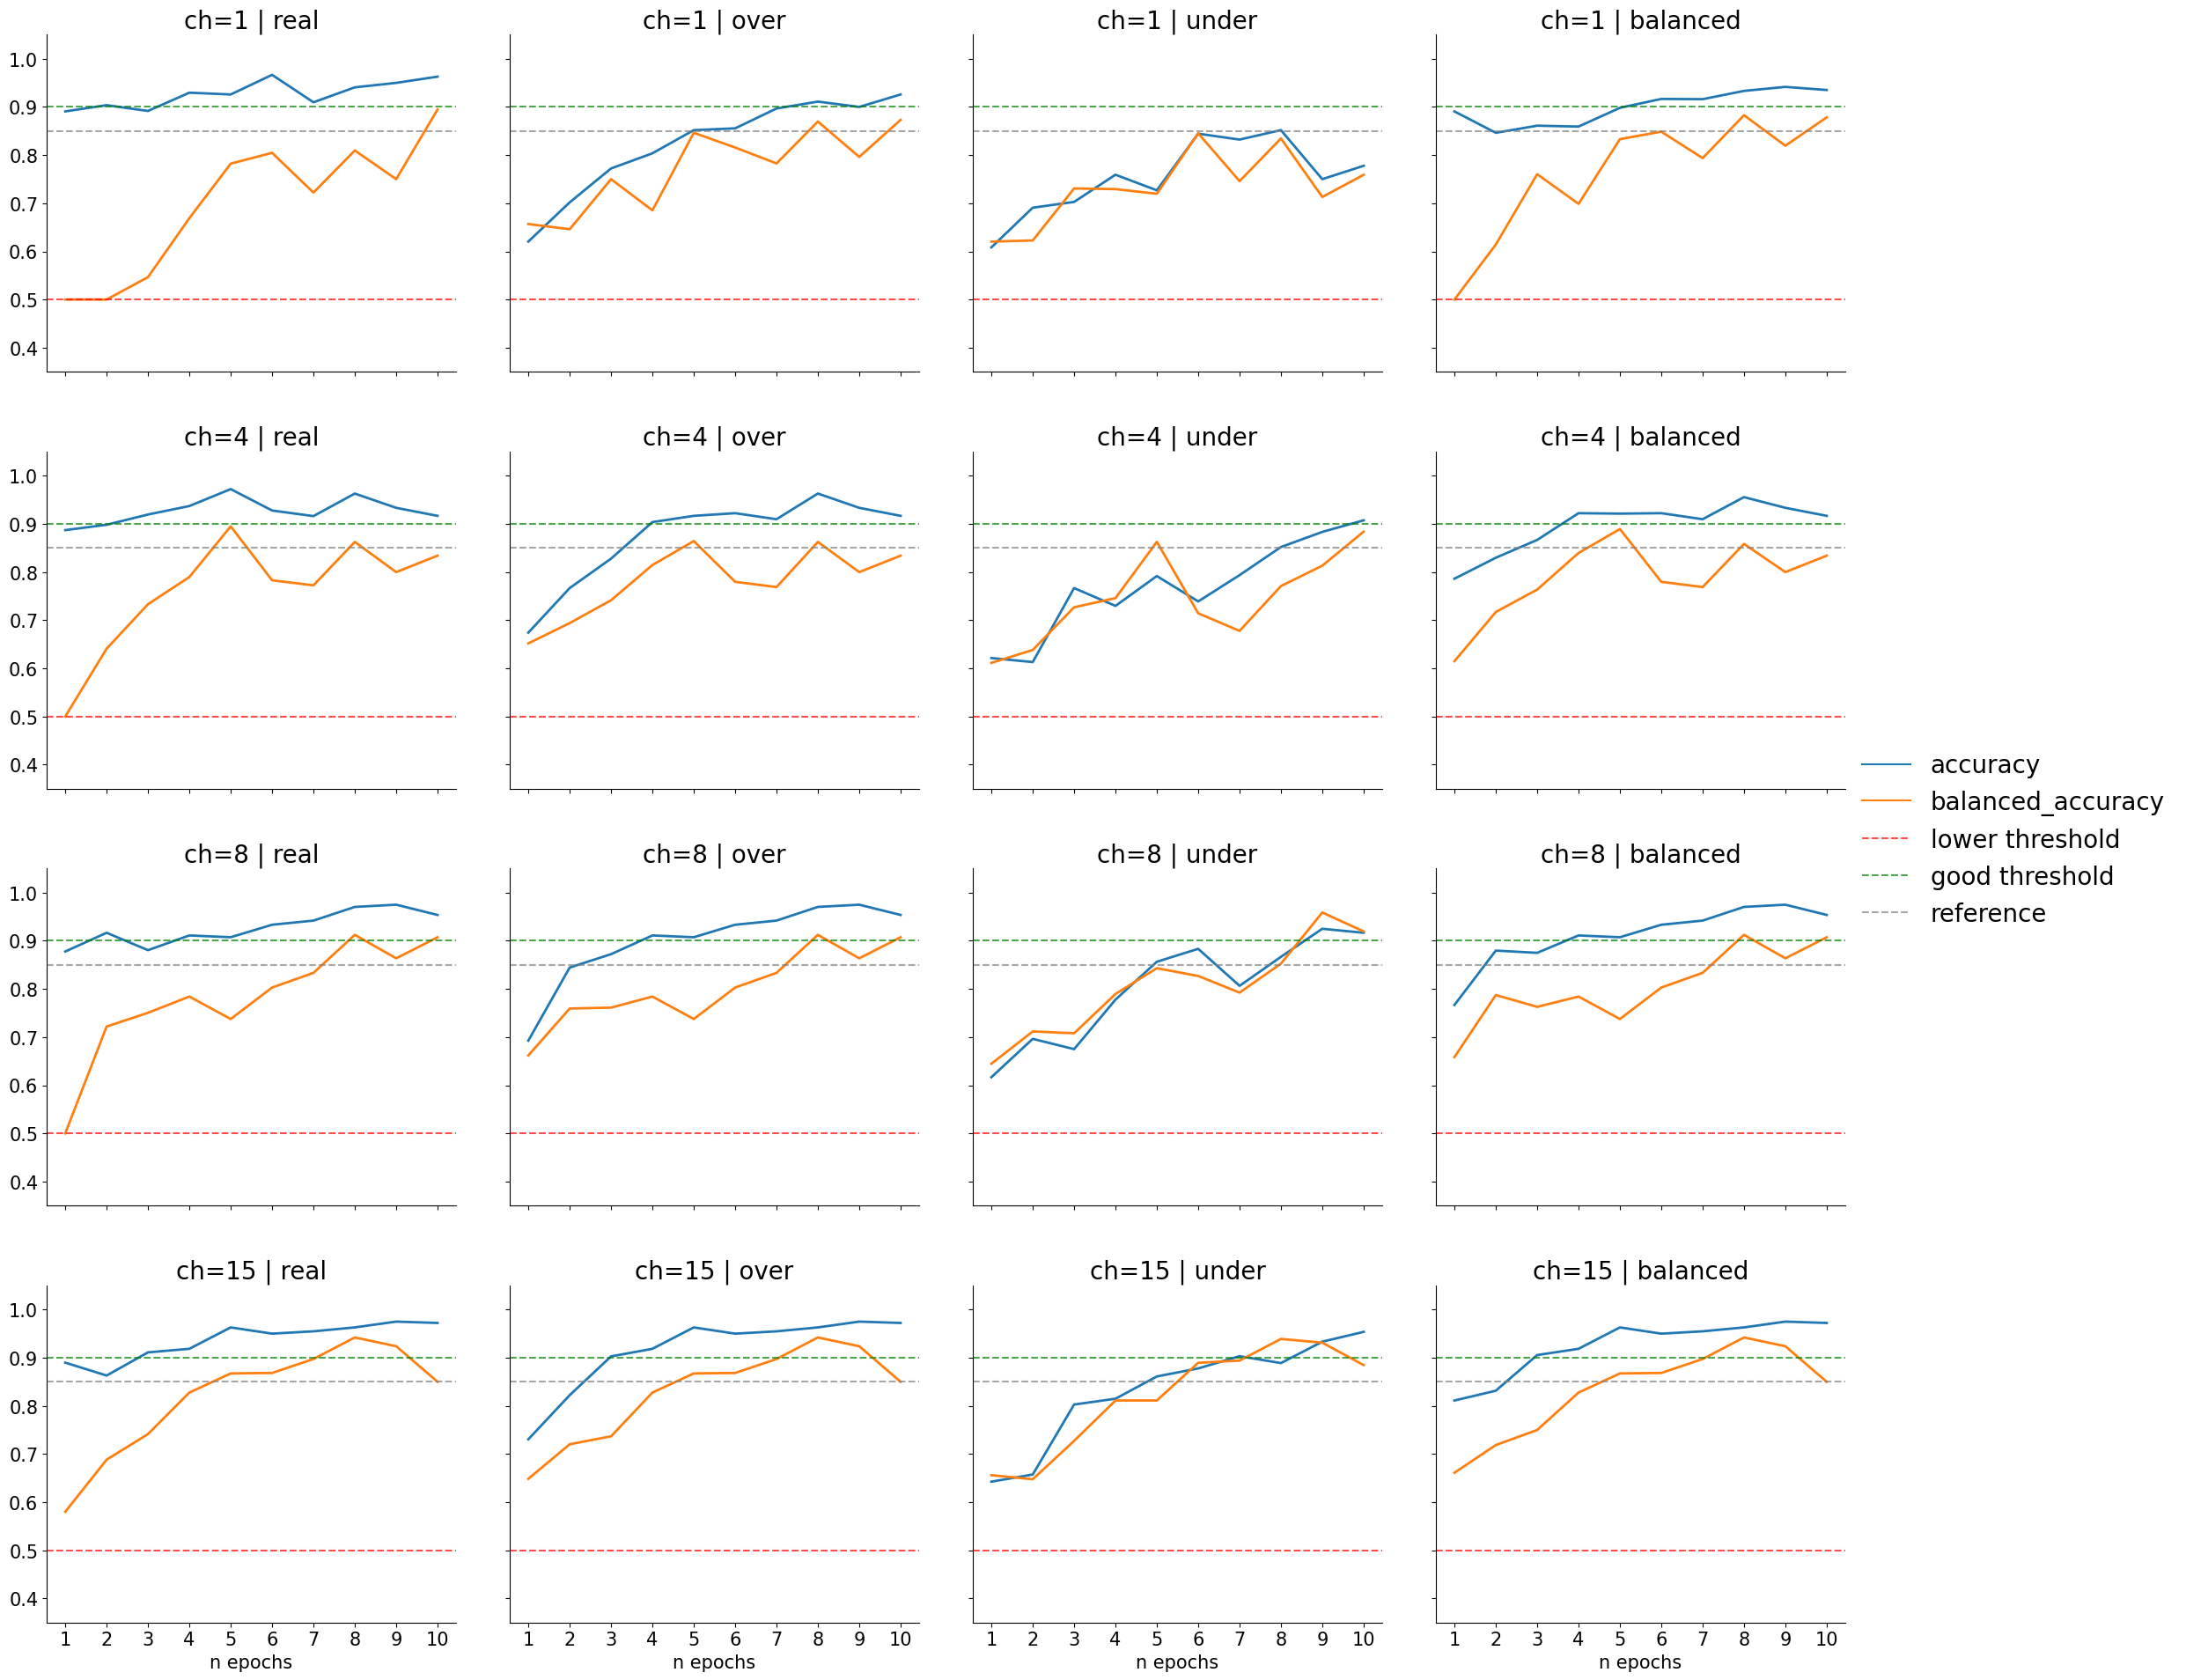

In [29]:
# 35 Hz
df = pd.read_csv('one_subject_channels_x_n_epochs_35Hz.csv')
with plt.rc_context({'xtick.labelsize':15,
                     'ytick.labelsize':15}):
    g = sns.relplot(df[(df.model=='SVM') & (df.metric.isin(['accuracy', 'balanced_accuracy']))],
                    x='n_epochs', y='value', hue='metric', col='sampling', row='n_ch', kind='line', linewidth=2)
    g.set_titles('ch={row_name} | {col_name}', size=20)
    g.map(plt.axhline, y=0.5, c='r', ls='--', label='lower threshold', alpha=0.7)
    g.map(plt.axhline, y=0.9, c='green', ls='--', label='good threshold', alpha=0.7)
    g.map(plt.axhline, y=0.85, c='grey', ls='--', label='reference', alpha=0.7)
    g.set_ylabels('')
    g.set_xlabels('n epochs', size=15)
    g.set(ylim=(0.35,1.05), xticks=np.arange(1,11,1))
    g.fig.tight_layout(pad=4)
    g.legend.remove()
    g.add_legend(fontsize=20)
    # plt.savefig('epochs_one_subject_all_samplings.jpg', dpi=300)
    plt.show()

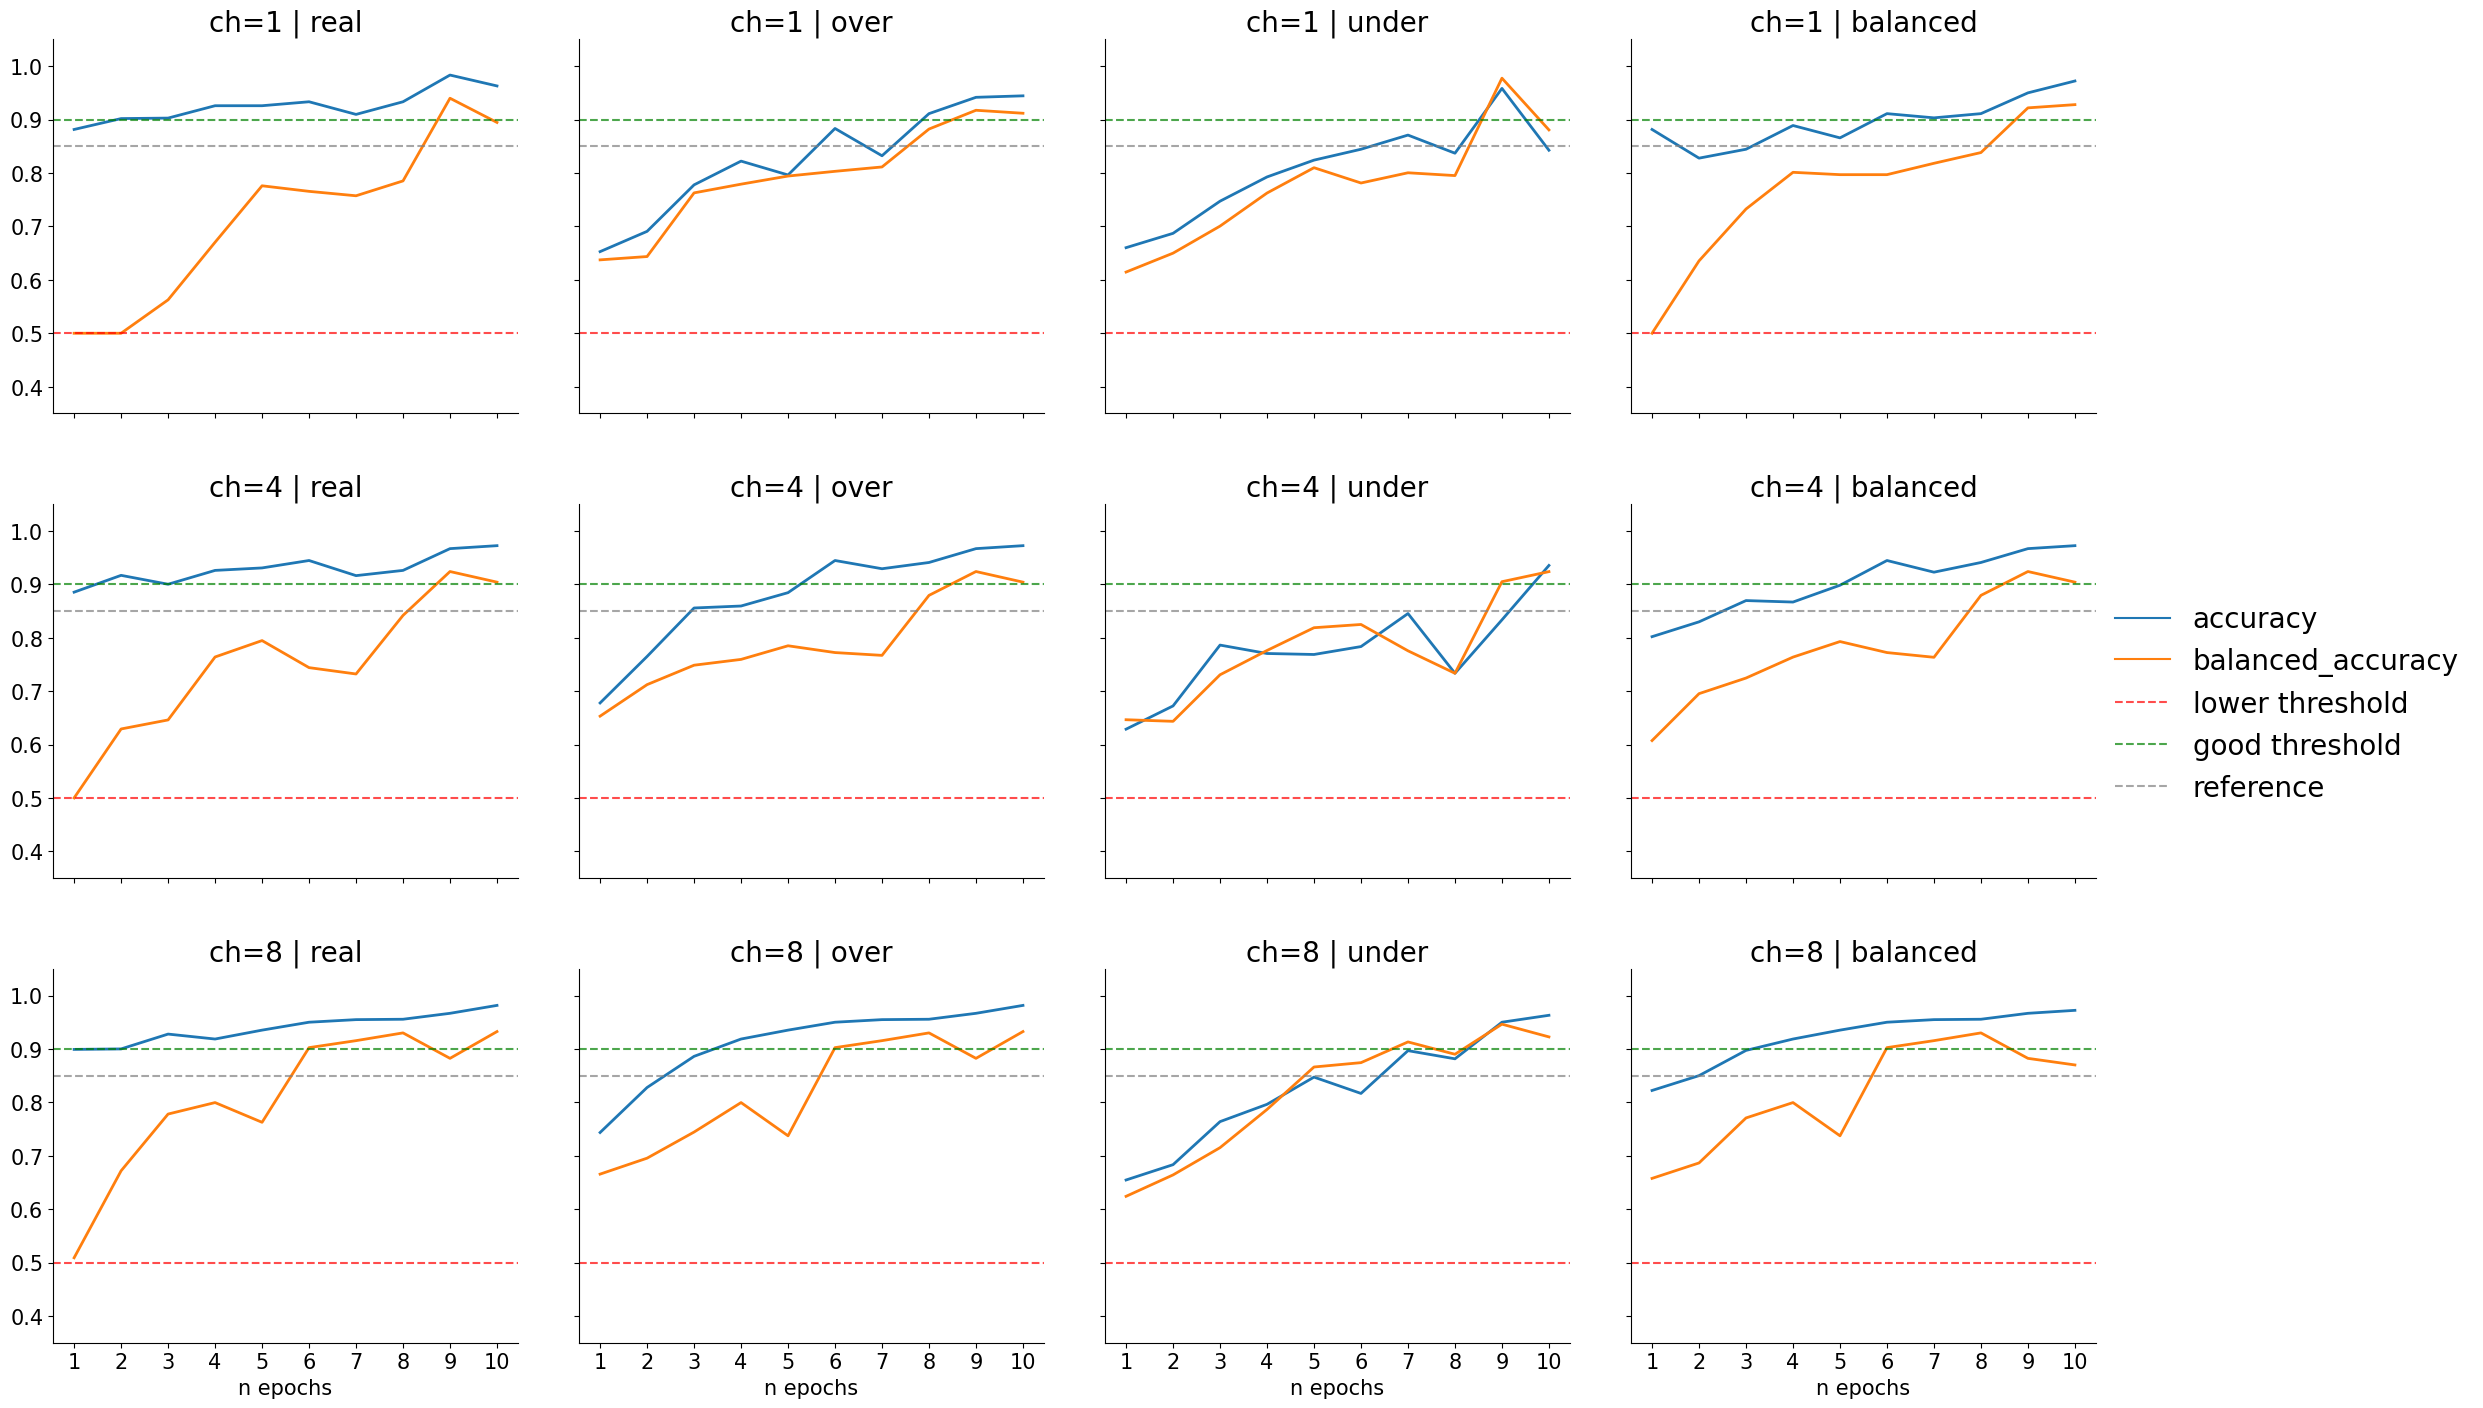

In [26]:
# 60 Hz, balanced svm
df = pd.read_csv('one_subject_channels_x_n_epochs_60Hz.csv')
with plt.rc_context({'xtick.labelsize':15,
                     'ytick.labelsize':15}):
    g = sns.relplot(df[(df.model=='SVM') & (df.metric.isin(['accuracy', 'balanced_accuracy']))],
                    x='n_epochs', y='value', hue='metric', col='sampling', row='n_ch', kind='line', linewidth=2)
    g.set_titles('ch={row_name} | {col_name}', size=20)
    g.map(plt.axhline, y=0.5, c='r', ls='--', label='lower threshold', alpha=0.7)
    g.map(plt.axhline, y=0.9, c='green', ls='--', label='good threshold', alpha=0.7)
    g.map(plt.axhline, y=0.85, c='grey', ls='--', label='reference', alpha=0.7)
    g.set_ylabels('')
    g.set_xlabels('n epochs', size=15)
    g.set(ylim=(0.35,1.05), xticks=np.arange(1,11,1))
    g.fig.tight_layout(pad=4)
    g.legend.remove()
    g.add_legend(fontsize=20)
    # plt.savefig('epochs_one_subject_all_samplings.jpg', dpi=300)
    plt.show()

При увеличение числа каналов и числа усреднений эпох качество классификации улучшается, как и было ожидаемо

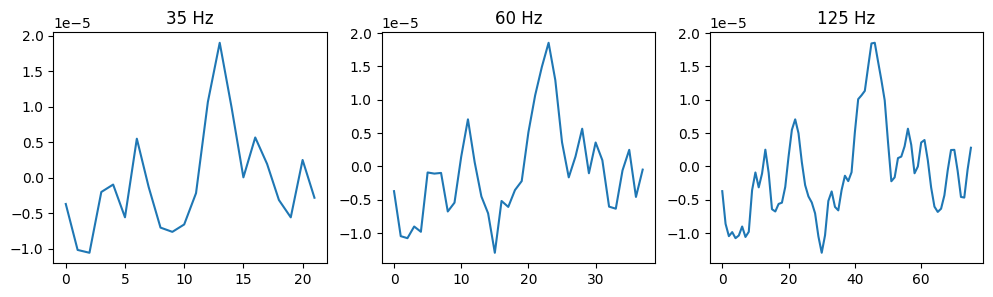

In [25]:
# проверка данных из архива кэша

n=1
plt.figure(figsize=(12,3))
for hz in ['35', '60', '125']:
    dataset = EEGDatasetAdvanced('./P300BCI_DataSet/', subjects=['ik'], load_cache=True, cache_dir_name=f'eeg_cache_{hz}Hz', transform=Flatten(0))
    dataset.pick_channels(['Pz'])
    plt.subplot(1,3,n)
    n+=1
    plt.plot(dataset[0][0])
    plt.title(f'{hz} Hz')
plt.show()
    

## Все-против-всех


In [56]:
# Датасет просто для того, чтобы достать список испытуемых
dataset = EEGDatasetAdvanced('./P300BCI_DataSet/', load_cache=True, cache_dir_name='eeg_cache_60Hz') 

In [57]:
subjects = dataset.available_subjects

In [83]:
# Словарь с тренировочными и тестовыми данными для всех испытуемых
datasets = dict((k, v) for k, v in zip(subjects, [{} for _ in range(len(subjects))]))
for subj in tqdm(subjects):
    dataset = EEGDataset('./P300BCI_DataSet/', subj)
    dataset.pick_channels(ch_set8)
    dataset.average(8)
    X = flatten(dataset.x[:,:,::14].copy()) # downsample -> 35 Hz
    y = dataset.y.copy()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)
    data = sampling(X=X_train, y=y_train)
    datasets[subj]['train_set'] = data
    datasets[subj]['x_test'] = X_test
    datasets[subj]['y_test'] = y_test
    

100%|██████████| 35/35 [03:14<00:00,  5.57s/it]


In [84]:
datasets['ik']['x_test'].shape

(135, 176)

In [67]:
def test_loop(dataset:dict, res_dict:dict, scaler, subj_train, sampling, *models, models_names=None):
    '''Run all vs all crossvalidataion tests for one train subject'''
    for subj_test, test_set in tqdm(dataset.items(), leave=False):
        x_test = scaler.transform(test_set['x_test'])
        y_test = test_set['y_test']
        for name, model in zip(models_names, models):
            res_dict['train'].append(subj_train)
            res_dict['test'].append(subj_test)
            res_dict['model'].append(name)
            res_dict['sampling'].append(sampling)
            y_pred = model.predict(x_test)
            scores = get_scores(y_test, y_pred)
            res_dict = expand_dict(res_dict, scores)
            
def expand_dict(base, addon):
    '''Expand base dict with addon dict'''
    
    for k, v in addon.items():
        if k in base.keys():
            base[k].append(v)
        else:
            base[k]=[v]
    return base        


In [85]:
# Циклы для итерации по испытуемым и формам семплирования

res_dict = {'train':[], 'test':[], 'model':[], 'sampling':[]}

for subj_train, dataset in tqdm(datasets.items()):
    
    train_set = dataset['train_set']
    
    for sampl, data in train_set.items():
        X_train = data['x']
        y_train = data['y']
        
        scaler = RobustScaler().fit(X_train)
        X_train = scaler.transform(X_train)
        
        lda = LDA().fit(X_train, y_train)
        svm = SVC(kernel='linear', random_state=42).fit(X_train, y_train)
        
        test_loop(datasets, res_dict, scaler, subj_train, sampl, lda, svm, models_names=['LDA', 'SVM'])

100%|██████████| 35/35 [00:54<00:00,  1.55s/it]


In [86]:
res = pd.DataFrame(res_dict)
res.rename(columns={'models':'model'}, inplace=True)
res = res.melt(id_vars=['train', 'test', 'model', 'sampling'], var_name='metric')
res_lda = res[res.model=='LDA']
res_svm = res[res.model=='SVM']
res_svm.head()

,train,test,model,sampling,metric,value
1,ak,ak,SVM,real,accuracy,0.962963
3,ak,as,SVM,real,accuracy,0.872180
5,ak,az,SVM,real,accuracy,0.844444
7,ak,dad,SVM,real,accuracy,0.850746
9,ak,dkv,SVM,real,accuracy,0.874074


In [73]:
res_svm.metric.unique()

array(['accuracy', 'balanced_accuracy', 'f1', 'precision', 'recall'],
      dtype=object)

In [87]:
# res.to_csv('all_vs_all_35Hz_8ch_8ep.csv')

In [ ]:
res = df.query(" models!='SVMb' & metric in ['accuracy', 'balanced_accuracy', 'f1'] ")
# res_lda = res[res.models=='LDA']
# res_svm = res[res.models=='SVM']

In [74]:
def draw_heatmap(*args, **kwargs):
    data = kwargs.pop('data')
    d = data.pivot(index=args[1], columns=args[0], values=args[2])
    sns.heatmap(d,**kwargs)

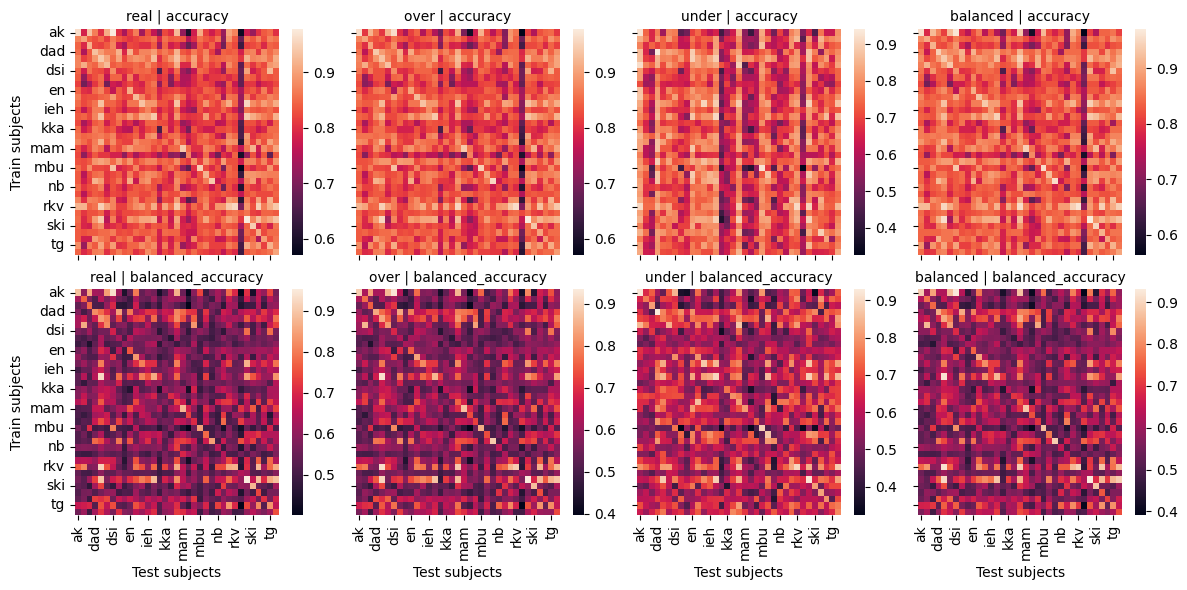

In [88]:
g = sns.FacetGrid(res_svm[res_svm.metric.isin(['accuracy', 'balanced_accuracy'])], col='sampling', row='metric')
g.set_titles('{col_name} | {row_name}')
# g.map_dataframe(draw_heatmap, 'train', 'test', 'value', vmin=0.4 ,vmax=1)
g.map_dataframe(draw_heatmap, 'train', 'test', 'value')
g.set_xlabels('Test subjects')
g.set_ylabels('Train subjects')
plt.savefig('all_vs_all_lda.jpg', dpi=300)
plt.show()

Для accuracy и balanced accuracy видим характерную диагональ, т.е. на своих собственных данных модаль работает хорошо, и, в основном, хуже для других испытыуемых.